In [1]:
# just importing some general libraries
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import os 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# it is useful to set the project directory to the data folder 
os.chdir('/kaggle/input/hp-supply-chain-optimization')

## Data Analysis

In [3]:
train_df = pd.read_csv('train.csv')

In [4]:
train_df

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0
...,...,...,...,...,...,...,...,...,...,...,...
15449,202317-247737,2023-04-29,202317,247737,15,Arale,10637,13.3,Premium,0.0,62.0
15450,202317-247737,2023-04-29,202317,247737,24,Arale,10637,13.3,Premium,0.0,3.0
15451,202318-247737,2023-05-06,202318,247737,3,Arale,10637,13.3,Premium,22.0,0.0
15452,202318-247737,2023-05-06,202318,247737,15,Arale,10637,13.3,Premium,68.0,78.0


In [5]:
# quickly and without looking we'll just drop any NA values
train_df = train_df.dropna()

In [6]:
# we'll also remove duplicates based on arbitrary columns 
train_df = train_df.drop_duplicates(['id', 'year_week', 'product_number'])

In [7]:
# it is useful to set the correct type for the date for some plotting functions
train_df['date'] = pd.to_datetime(train_df['date'])

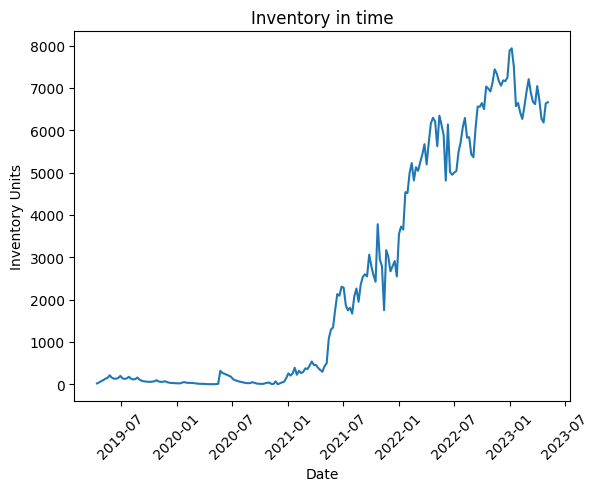

In [8]:
gd = train_df.groupby('date').sum(numeric_only = True)
plt.plot(gd.index, gd.inventory_units)
plt.xticks(rotation = 45)
plt.xlabel('Date') 
plt.ylabel('Inventory Units')
plt.title('Inventory in time')
plt.show()

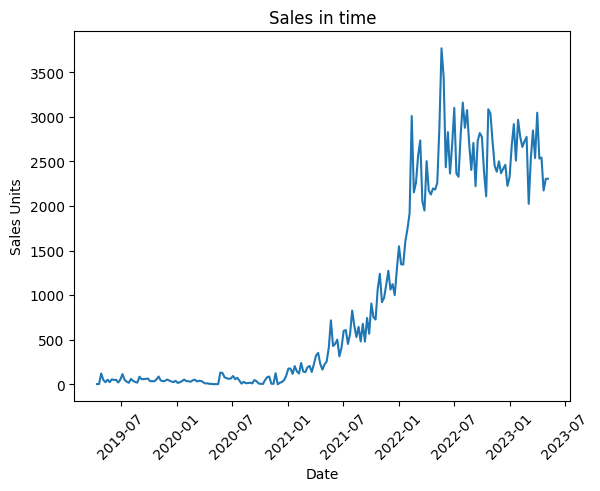

In [9]:

plt.plot(gd.index, gd.sales_units)
plt.xticks(rotation = 45)
plt.xlabel('Date') 
plt.ylabel('Sales Units')
plt.title('Sales in time')
plt.show()

In [10]:
# let's create some grouped tables
gd_product_number = train_df.groupby(['date', 'product_number']).sum(numeric_only = True).reset_index()
products = gd_product_number.product_number.unique()
gd_prod_category = train_df.groupby(['date', 'prod_category']).sum(numeric_only = True).reset_index()
prod_categories = gd_prod_category.prod_category.unique()

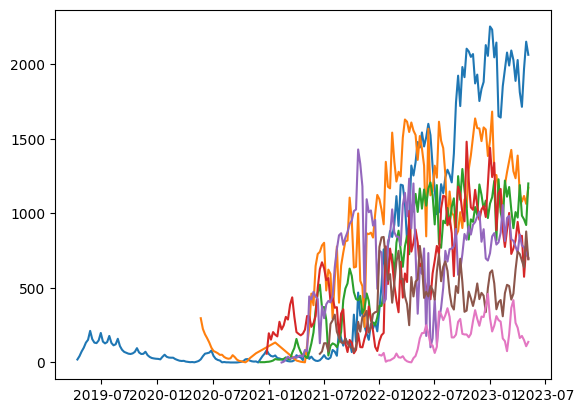

In [11]:
for prod in prod_categories: 
    gd_prod = gd_prod_category[gd_prod_category.prod_category == prod]
    plt.plot(gd_prod.date, gd_prod.inventory_units)
    
plt.show()

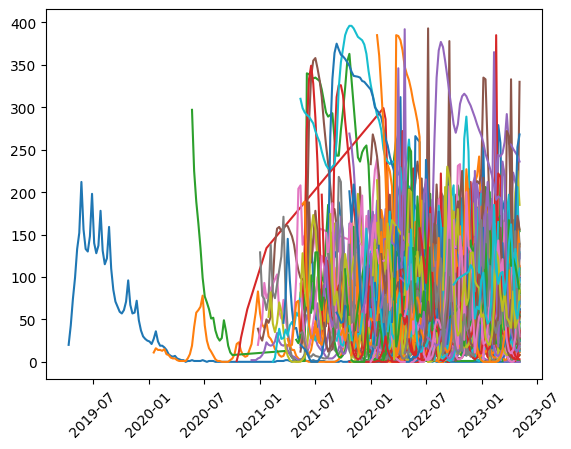

In [12]:
for prod in products: 
    gd_prod = gd_product_number[gd_product_number.product_number == prod]
    plt.plot(gd_prod.date, gd_prod.inventory_units)
    
plt.xticks(rotation = 45)    
plt.show()

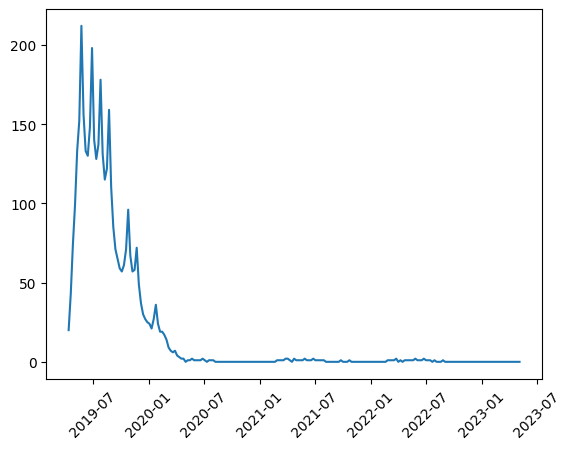

In [13]:
gd_product_number = gd_product_number[gd_product_number.product_number == 233919]
for prod in products: 
    gd_prod = gd_product_number[gd_product_number.product_number == prod]
    plt.plot(gd_prod.date, gd_prod.inventory_units)
    
plt.xticks(rotation = 45)    
plt.show()

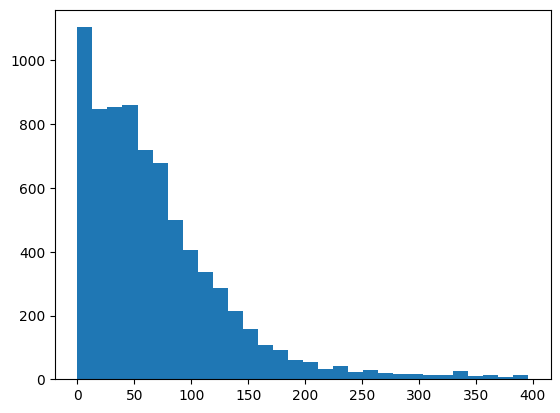

In [14]:
plt.hist(train_df.inventory_units, bins = 30)
plt.show()

In [15]:
# it's interesting to know the correlation among variables
train_df.corr(numeric_only = True)

,year_week,product_number,reporterhq_id,specs,display_size,sales_units,inventory_units
year_week,1.000000,-0.025631,-0.175238,0.110215,0.026316,-0.007130,-0.004772
product_number,-0.025631,1.000000,0.086757,-0.257812,0.213241,-0.020295,-0.015819
reporterhq_id,-0.175238,0.086757,1.000000,-0.133474,0.047039,-0.056598,0.157138
specs,0.110215,-0.257812,-0.133474,1.000000,0.109194,-0.056674,-0.042583
display_size,0.026316,0.213241,0.047039,0.109194,1.000000,-0.064979,-0.075021
sales_units,-0.007130,-0.020295,-0.056598,-0.056674,-0.064979,1.000000,0.069085
inventory_units,-0.004772,-0.015819,0.157138,-0.042583,-0.075021,0.069085,1.000000


## Modeling

In [16]:
# our very simple ultra small data prep function
def prepare_df(df):
    df = df[['year_week', 'product_number', 'prod_category', 'segment']]
    df = pd.get_dummies(df, columns=['product_number', 'segment', 'prod_category'])
    return df

In [17]:
X_train = prepare_df(train_df)
y_train = train_df.inventory_units

In [18]:
y_train

0         35.0
1         70.0
2        137.0
3        274.0
4        333.0
         ...  
15439      0.0
15442      0.0
15445      0.0
15448      0.0
15451      0.0
Name: inventory_units, Length: 7542, dtype: float64

In [19]:
# the best model in the world
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = lm_model.predict(X_train)
y_true = y_train

In [21]:
# just checking the error on the training predictions
rms = mean_squared_error(y_true, y_pred, squared=False)
rms

56.720844553427696

## Test Data Predictions

In [22]:
# this is an example on how data must be submitted
pd.read_csv('sample_submission.csv')

,id,inventory_units
0,202319-105609,0
1,202319-107583,0
2,202319-10857,0
3,202319-109557,0
4,202319-112518,0
...,...,...
1295,202331-92778,0
1296,202331-93765,0
1297,202331-94752,0
1298,202331-9870,0


In [23]:
# we need to prepare the test data 
# and fill empty values before we can submit it
test_df = pd.read_csv('test.csv')
test_df[['year_week', 'product_number']] = test_df.id.str.split('-', expand = True)
test_df['product_number'] = test_df.product_number.astype(int)
test_df

,id,year_week,product_number
0,202319-105609,202319,105609
1,202319-107583,202319,107583
2,202319-10857,202319,10857
3,202319-109557,202319,109557
4,202319-112518,202319,112518
...,...,...,...
1295,202331-92778,202331,92778
1296,202331-93765,202331,93765
1297,202331-94752,202331,94752
1298,202331-9870,202331,9870


In [24]:
# each product has specific information, we are just creating a reference table
product_mapping = train_df[['product_number', 'prod_category', 'segment', 'specs', 'display_size']].drop_duplicates()
product_mapping

,product_number,prod_category,segment,specs,display_size
0,6909,Arale,Premium,21274,13.3
137,7896,Goku,Core,126677,14.0
275,8883,Goku,Core,96700,15.6
460,9870,Doraemon,Gaming,107337,15.6
614,10857,Doraemon,Gaming,108304,15.6
...,...,...,...,...,...
14604,238854,Goku,Core,117007,15.6
14742,239841,Goku,Core,95733,15.6
14878,240828,Conan,Premium,2901,13.3
15015,242802,Conan,Premium,3868,13.3


In [25]:
test_df_complete = test_df.merge(product_mapping, on='product_number', how = 'left')
test_df_complete

,id,year_week,product_number,prod_category,segment,specs,display_size
0,202319-105609,202319,105609,Goku,Gaming,166324,15.6
1,202319-107583,202319,107583,Clover,Core,206938,15.6
2,202319-10857,202319,10857,Doraemon,Gaming,108304,15.6
3,202319-109557,202319,109557,Goku,Core,141182,14.0
4,202319-112518,202319,112518,Conan,Premium,157621,15.6
...,...,...,...,...,...,...,...
1295,202331-92778,202331,92778,Goku,Core,140215,14.0
1296,202331-93765,202331,93765,Arale,Premium,155687,14.0
1297,202331-94752,202331,94752,Clover,Core,224344,14.0
1298,202331-9870,202331,9870,Doraemon,Gaming,107337,15.6


In [26]:
X_test = prepare_df(test_df_complete)
y_pred = lm_model.predict(X_test)

In [27]:
# this is an example submission
submission = pd.DataFrame({
    'id' : test_df_complete.id,
    'inventory_units' : y_pred
})

submission

,id,inventory_units
0,202319-105609,73.202907
1,202319-107583,89.782193
2,202319-10857,52.273549
3,202319-109557,40.382651
4,202319-112518,184.665891
...,...,...
1295,202331-92778,46.001934
1296,202331-93765,56.158345
1297,202331-94752,81.946672
1298,202331-9870,59.252312


In [28]:
# to submit a kaggle notebook you must save the submission.csv file inside /kaggle/working directory 
# remember to skip the index before writing the file
submission.to_csv('/kaggle/working/submission.csv', index = False)